In [2]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
import cv2

In [3]:
IMG_SIZE = 224
NUM_EPOCHS = 100
NUM_CLASSES = 3
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32

In [4]:
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=[0.9, 1.25],
                                horizontal_flip=True,
                                vertical_flip=False,
                                data_format='channels_last',
                                brightness_range=[0.5, 1.5]
                               )
                                       
train_generator = data_generator_with_aug.flow_from_directory(
            'FIRE-SMOKE-DATASET/Train',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TRAIN_BATCH_SIZE,
            class_mode='categorical')
    

validation_generator = data_generator_with_aug.flow_from_directory(
            'FIRE-SMOKE-DATASET/Test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=TEST_BATCH_SIZE,
            shuffle = False,
            class_mode='categorical')

Found 2700 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [ ]:
model_name_vgg16 = "vgg16.h5"

# define  callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_vgg16, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [7]:
def vgg16_pretrained(lr=1e-3):
    my_new_model = Sequential()
    vgg_weights_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
    vgg= VGG16(include_top=False, weights=vgg_weights_path ) 
    vgg.summary()
    my_new_model.add(vgg)
    my_new_model.add(GlobalAveragePooling2D())
    my_new_model.layers[0].trainable = False
    my_new_model.layers[1].trainable = False
      
    my_new_model.add(Dense(4096, activation='relu'))
    my_new_model.add(Dense(1000, activation='relu'))      
    my_new_model.add(Dense(NUM_CLASSES, activation='softmax'))
    my_new_model.compile(optimizer = Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return my_new_model

In [9]:
def vgg16(ishape=(IMG_SIZE,IMG_SIZE,3), drop=0.1, lr=1e-3):
    out_layers = 64
    input_img = Input(shape=ishape)
    x = Conv2D(out_layers, (3,3), activation="relu", padding="same")(input_img)
    x = Conv2D(out_layers, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*2, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*2, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*4, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = Conv2D(out_layers*8, (3,3), activation="relu", padding="same")(x)
    x = MaxPooling2D()(x)
    x = GlobalMaxPooling2D()(x)
    
    x = Dropout(rate=drop)(x)
    x = Dense(4096, activation="relu")(x)
    x = Dropout(rate=drop)(x)
    x = Dense(1000, activation="relu")(x)
    x = Dropout(rate=drop)(x)
    x = Dense(NUM_CLASSES, activation="softmax")(x)
    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer = Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [8]:
model = vgg16_pretrained()
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
history = model.fit(train_generator, epochs = NUM_EPOCHS, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(validation_generator))

Epoch 1/100
85/85 [==============================] - 235s 3s/step - loss: 3.8935 - accuracy: 0.7250 - val_loss: 0.2726 - val_accuracy: 0.9200
Epoch 2/100
85/85 [==============================] - 244s 3s/step - loss: 0.1940 - accuracy: 0.9328 - val_loss: 0.3821 - val_accuracy: 0.8700
Epoch 3/100
85/85 [==============================] - 248s 3s/step - loss: 0.1574 - accuracy: 0.9431 - val_loss: 0.3396 - val_accuracy: 0.8867
Epoch 4/100
85/85 [==============================] - 246s 3s/step - loss: 0.1104 - accuracy: 0.9650 - val_loss: 0.3361 - val_accuracy: 0.8900
Epoch 5/100
85/85 [==============================] - 247s 3s/step - loss: 0.0928 - accuracy: 0.9694 - val_loss: 0.3572 - val_accuracy: 0.8867
Epoch 6/100
85/85 [==============================] - 248s 3s/step - loss: 0.0584 - accuracy: 0.9737 - val_loss: 0.3578 - val_accuracy: 0.9067
Epoch 7/100
85/85 [==============================] - 251s 3s/step - loss: 0.0484 - accuracy: 0.9841 - val_loss: 0.2898 - val_accuracy: 0.9133
Epoch 

In [14]:
def plot_history( H, NUM_EPOCHS ):
    plt.style.use("ggplot")
    fig = plt.figure()
    fig.set_size_inches(15, 5)
    fig.add_subplot(1, 3, 1)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.title("Training Loss and Validation Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    fig.add_subplot(1, 3, 2)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["accuracy"], label="train_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    fig.add_subplot(1, 3, 3)
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_accuracy"], label="val_acc")
    plt.title("Validation Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.show()

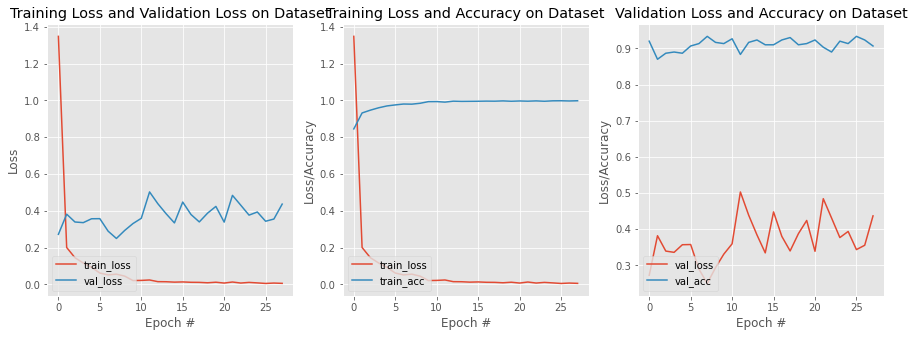

In [16]:
plot_history(history,28)

In [9]:
model.load_weights("vgg16.h5")

In [12]:
import math
def draw_prediction( frame, class_string ):
    
    x_start = 10
    cv2.putText(frame, class_string, (x_start, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
    return frame

def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

def get_label_dict(train_generator ):
# Get label to class_id mapping
    labels = (train_generator.class_indices)
    label_dict = dict((v,k) for k,v in labels.items())
    return  label_dict   

def get_display_string(pred_class, label_dict):
    txt = ""
    for c, confidence in pred_class:
        txt += label_dict[c]
        if c != 1:
            txt += '['+ str(confidence) +']'
    
    return txt

def predict(  model, video_path, filename, label_dict ):
    
    vs = cv2.VideoCapture(video_path)
    fps = math.floor(vs.get(cv2.CAP_PROP_FPS))
    ret_val = True
    writer = 0
    
    while True:
        ret_val, frame = vs.read()
        if not ret_val:
            break
       
        resized_frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame_for_pred = prepare_image_for_prediction( resized_frame )
        pred_vec = model.predict(frame_for_pred)
        
        pred_class =[]
        confidence = np.round(pred_vec.max(),2) 
        
        if confidence > 0.4:
            pc = pred_vec.argmax()
            pred_class.append( (pc, confidence) )
        else:
            pred_class.append( (0, 0) )
        if pred_class:
            txt = get_display_string(pred_class, label_dict)       
            frame = draw_prediction( frame, txt )
        
        if not writer:
            fourcc = cv2.VideoWriter_fourcc(*"XVID")
            writer = cv2.VideoWriter(filename, fourcc, fps,(frame.shape[1], frame.shape[0]), True)
            
        # write out
        writer.write(frame)
        
    vs.release()
    writer.release()

In [13]:
label_dict = get_label_dict(train_generator)
video_path = "ForestFire1.avi"
predict ( model, video_path, 'Fire1_pred.avi',  label_dict) 
video_path = "sMoky.avi"
predict ( model, video_path, 'Smoke1_pred.avi',  label_dict) 
video_path = "Pelco_Colakli.avi"
predict ( model, video_path, 'Other1_pred.avi',  label_dict) 
video_path = "barbeqraw.avi"
predict ( model, video_path, 'Smoke2_pred.avi',  label_dict) 